# Imports and data loading

In [2]:
!pip install -qU pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Imbalanced-learn imports for handling class imbalance and integration in a pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# 1. Load and inspect the dataset
df = pd.read_csv('online_shoppers_intention.csv')

Matplotlib is building the font cache; this may take a moment.


# EDA

In [4]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())



Dataset Shape: (12330, 18)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non

This initial step helps us understand the dataset’s structure and basic properties:

Dataset Shape and Info:
The output shows that the dataset has 12,330 rows and 18 columns. Using df.info(), we see details for each column including data type (e.g., integers, floats, objects, booleans) and that there are no missing values—all 12,330 entries per column are non-null. This is crucial because it tells us our data is complete and we can proceed without needing to handle missing data.

First 5 Rows and Summary Statistics:
By displaying the first 5 rows with df.head(), we get a glimpse of actual values across columns, such as the number of administrative pages visited, session durations, and categorical variables like 'Month' and 'VisitorType'. The df.describe() output provides summary statistics (mean, standard deviation, min, quartiles, max) for numerical features. For example, the 'Administrative' column has a mean of ~2.32 and a maximum of 27, indicating a wide range of behaviors. Additionally, reviewing the target variable 'Revenue' confirms a class imbalance (~15.5% True vs. ~84.5% False), a key insight for later modeling steps.

---

In [5]:
# Check the distribution of the target variable 'Revenue'
print("\nTarget Variable Distribution (Revenue):")
print(df['Revenue'].value_counts(normalize=True))
print(df['Revenue'].value_counts())




Target Variable Distribution (Revenue):
Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64
Revenue
False    10422
True      1908
Name: count, dtype: int64


The output tells us that the target variable, 'Revenue', is highly imbalanced: about 84.5% of the sessions did not result in a purchase (False) and only about 15.5% did (True). This means that out of 12,330 sessions, 10,422 are non-purchase sessions and 1,908 are purchase sessions. For an audience with a background in applied data science and AI, this imbalance is crucial because it can affect model performance—most classifiers might lean towards predicting the majority class unless techniques such as resampling, SMOTE, or cost-sensitive learning are applied to address this skew.

---

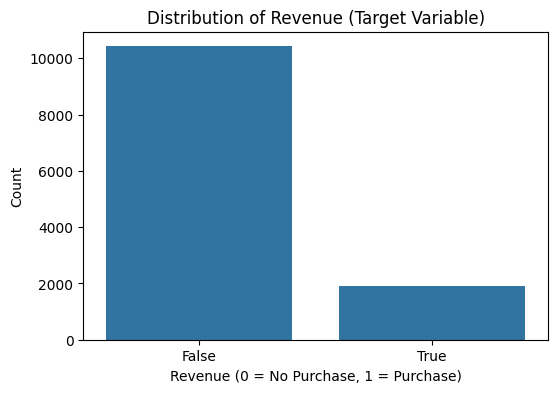

In [6]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Revenue', data=df)
plt.title("Distribution of Revenue (Target Variable)")
plt.xlabel("Revenue (0 = No Purchase, 1 = Purchase)")
plt.ylabel("Count")
plt.show()



This bar chart clearly shows that the dataset’s target variable—representing whether a session ends in a purchase—is highly imbalanced. The bar for "False" (no purchase) is significantly taller than the bar for "True" (purchase), indicating that only about 15.5% of sessions result in a purchase. This class imbalance has important implications for model building, as a naive classifier could predict “False” most of the time and still achieve high accuracy. Therefore, techniques such as SMOTE or cost-sensitive methods may be needed to ensure the minority “True” class is accurately captured.

---

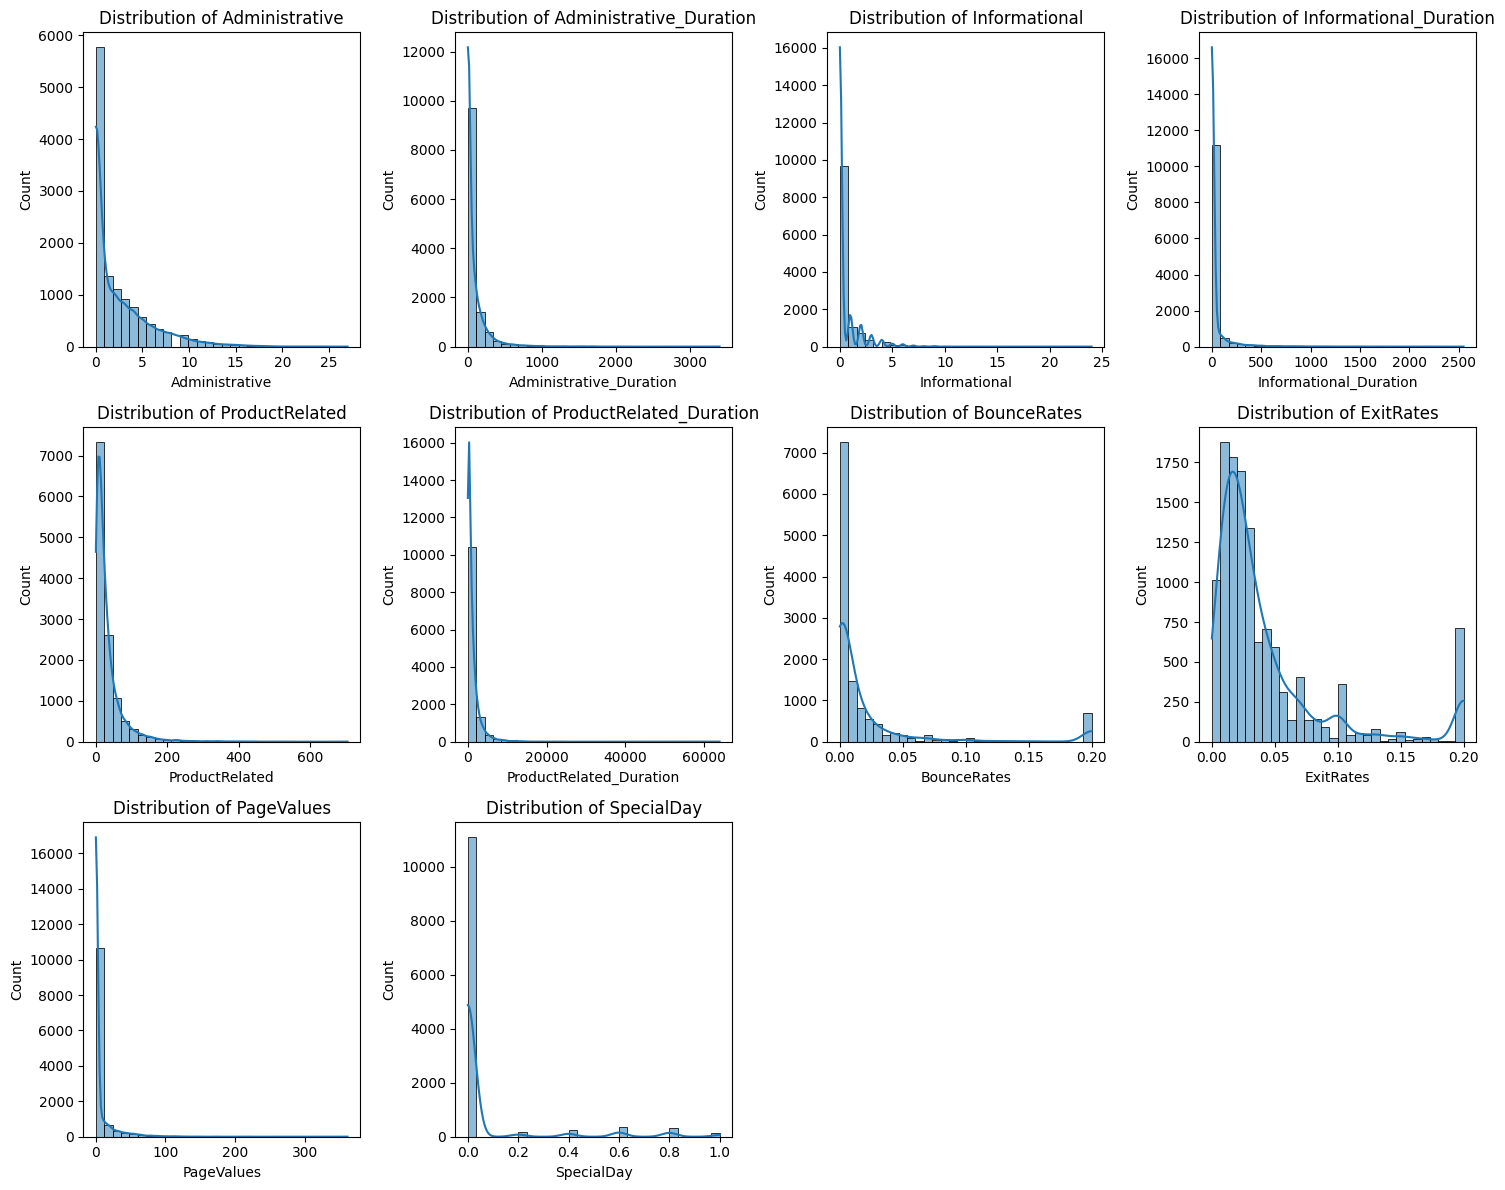

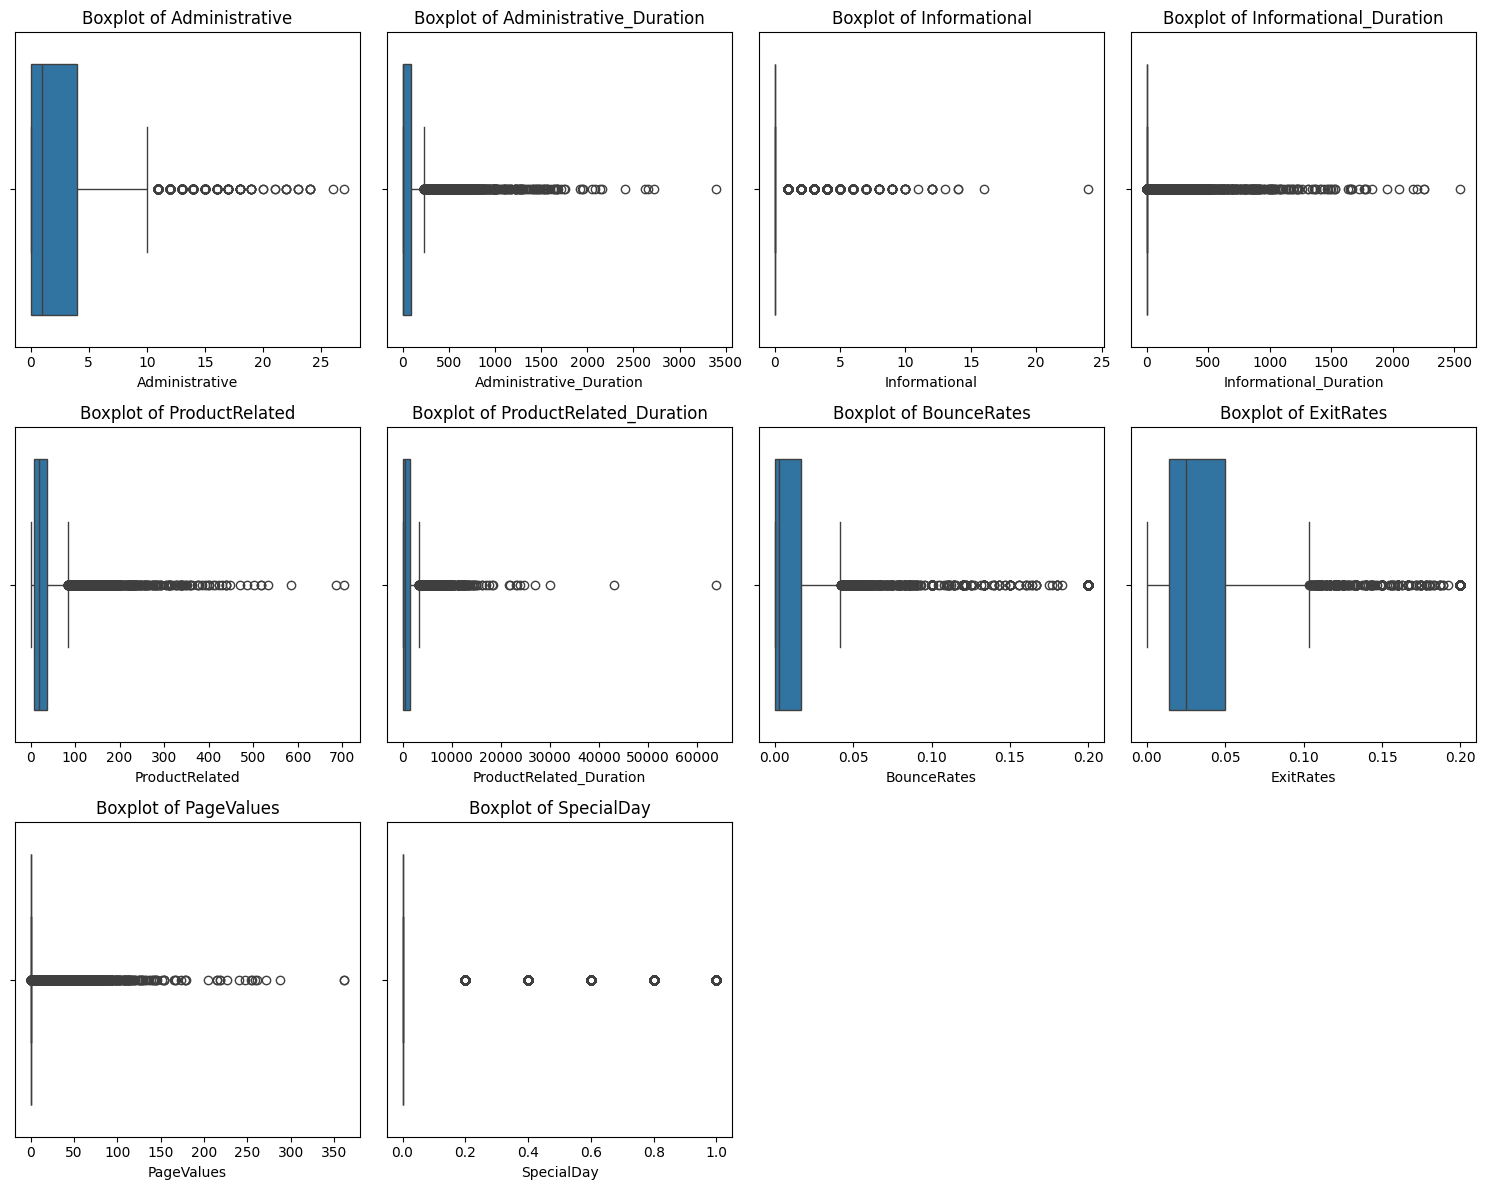

In [7]:
# 2. Visualize Distributions of Key Numerical Features
numerical_cols = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'
]

# Histograms for numerical features
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots for numerical features to inspect for outliers
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()



Overall Insights - numerical features

Heavily Right-Skewed Distributions: Most numerical features (e.g., Administrative, Informational, ProductRelated, and their corresponding durations) show a concentration of sessions at lower values, with a small subset extending to very high values.

Outliers Present: The boxplots reveal that a few sessions exhibit exceptionally large numbers of page visits or durations, potentially requiring special handling (e.g., robust scaling or outlier removal).

Sparse High-Value PageValues: A majority of sessions have zero PageValues, but a few sessions have high PageValues, indicating potential purchases or high-value interactions.

SpecialDay Mostly Zero: The SpecialDay variable is zero for most sessions and only spikes near specific calendar events, suggesting its effect might be significant but only for a small fraction of sessions.

Implication for Modeling: Given the skewness and outliers, transformations (like log transforms) or robust methods may help improve model performance. Additionally, the sparsity in some features (e.g., PageValues) will require careful consideration when selecting and engineering features for the predictive model.

---

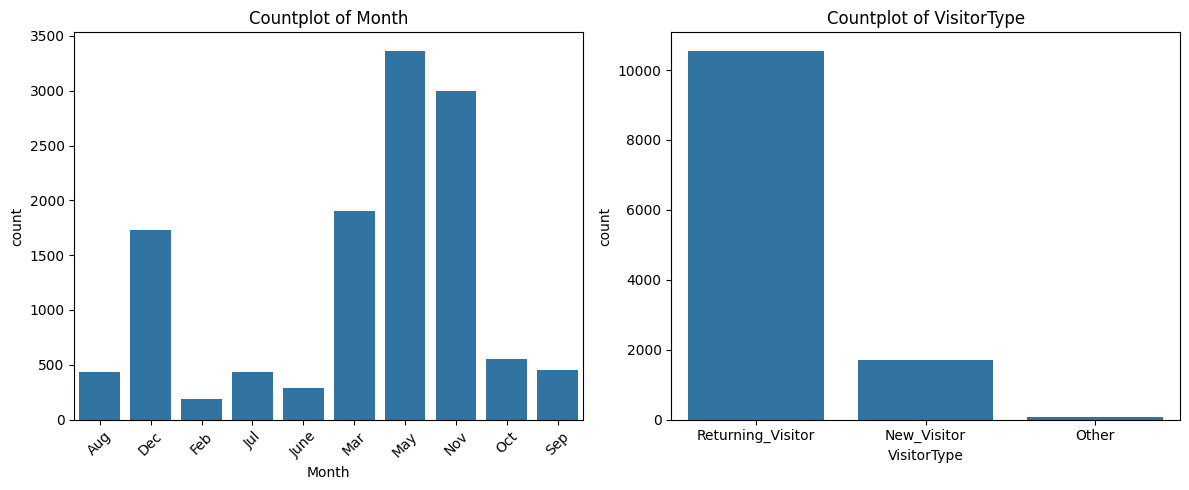

In [8]:
# 3. Visualize Categorical Variables
# Countplots for categorical features: 'Month' and 'VisitorType'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Month', data=df, order=sorted(df['Month'].unique()))
plt.title("Countplot of Month")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x='VisitorType', data=df)
plt.title("Countplot of VisitorType")

plt.tight_layout()
plt.show()



Insights from the Categorical Features

Month:
The countplot shows that the number of sessions varies significantly by month, with certain months (like May and November) having higher session counts. This suggests seasonality effects—possibly due to holiday sales or promotional events. From a modeling perspective, these variations in session frequency by month might correlate with different purchase behaviors and should be carefully considered (e.g., one-hot encoding or cyclical encoding).

VisitorType:
The majority of sessions come from “Returning_Visitor,” indicating a large proportion of repeat traffic. A smaller segment is “New_Visitor,” and an even smaller fraction is categorized as “Other.” This imbalance could influence the likelihood of purchase, as returning visitors may already be familiar with the site or products, potentially affecting conversion rates. Modeling approaches might therefore benefit from treating visitor type as a key feature, possibly interacting with other variables like time spent on site or page views.

---

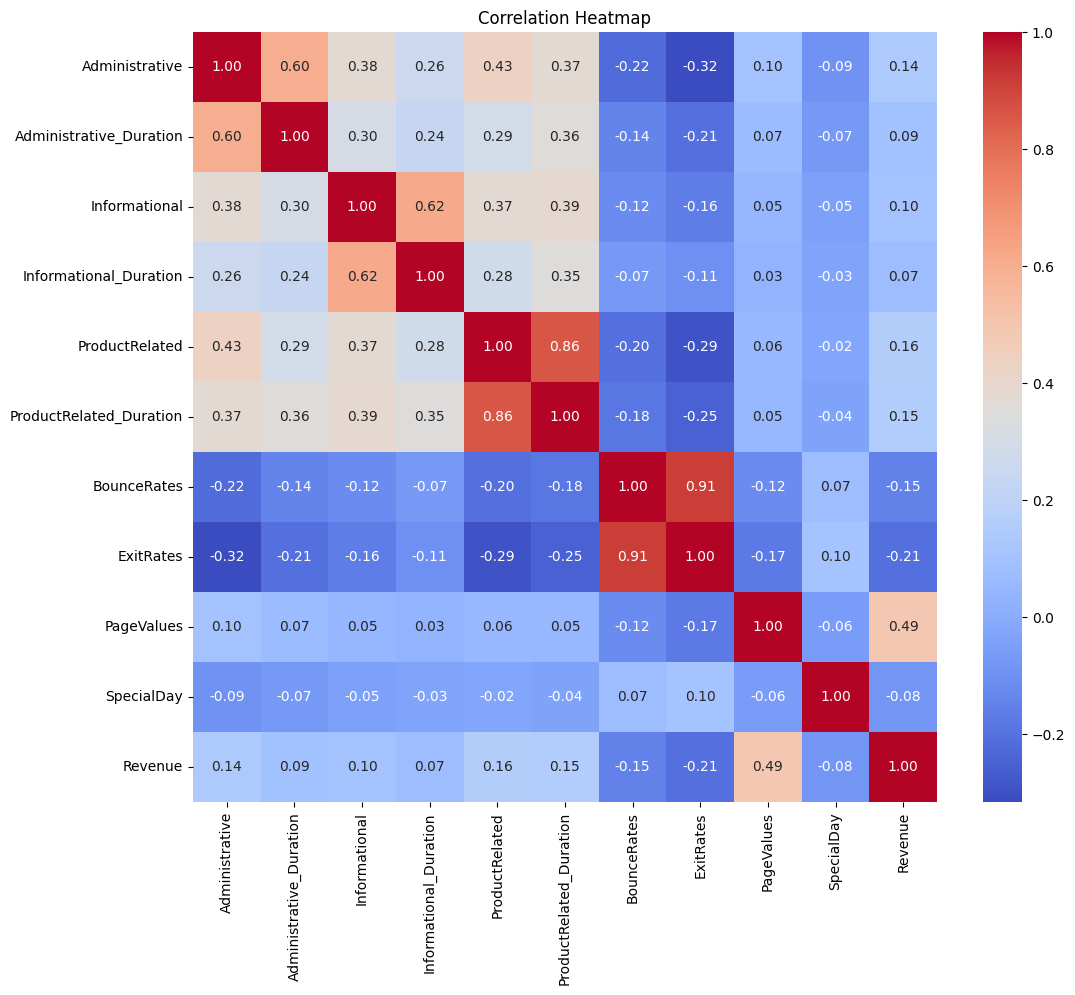

In [9]:
# 4. Correlation Analysis
# Compute correlation matrix for numerical features along with the target variable
corr_columns = numerical_cols + ['Revenue']
corr_matrix = df[corr_columns].corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



Key Takeaways from the Correlation Heatmap

Strongest Predictor: PageValues shows the highest positive correlation with Revenue, suggesting that sessions with higher page values are more likely to result in a purchase.

Moderate Associations: ProductRelated and ProductRelated_Duration also exhibit moderate positive correlations with Revenue. This aligns with the intuition that browsing more product pages or spending more time on them indicates higher purchase intent.

Negative Correlations: BounceRates and ExitRates have a negative relationship with Revenue, implying that sessions with higher bounce/exit rates are less likely to lead to a purchase.

Feature Collinearity: Features like Administrative and Administrative_Duration (and similarly for Informational and Informational_Duration) are positively correlated with each other, indicating potential multicollinearity. Careful consideration (e.g., dimensionality reduction or dropping redundant features) may be necessary when building models.

Modeling Implications: Correlation provides a linear snapshot. Non-linear relationships may still exist, so while these insights help guide feature selection, more advanced or tree-based models may capture interactions and non-linearities better.

---

# Modeling Pipeline

## Loading and Preparing Data:

**Data Separation:**
We separate the DataFrame df into features X and the target y (which is 'Revenue'). The target is converted to integers (0 or 1) for compatibility with our models.

In [10]:
# ---------------------
# 1. Load and Prepare Data
# ---------------------
# Assume the dataset is already loaded in a DataFrame called 'df'
# X: features; y: target variable
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)  # Convert boolean target to integer (0,1)

## Defining Feature Categories:

Numerical Features:
These include page counts, durations, bounce/exit rates, and others. Many of these features exhibit outliers, so we plan to use a robust scaler.

Categorical Features:
We select 'Month' and 'VisitorType' as categorical. These will be one-hot encoded so that our models can interpret them properly.

In [11]:
# ---------------------
# 2. Define Feature Categories
# ---------------------
# Numerical features (include those with outliers)
numerical_cols = [
    'Administrative', 'Administrative_Duration', 
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
    'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend'
]

# Categorical features (we choose features that are truly categorical)
categorical_cols = ['Month', 'VisitorType']

## Splitting Data:

Train/Test Split:
We use train_test_split with stratification based on the target variable to ensure that both the training and test sets reflect the same class distribution as the overall dataset.

In [12]:
# ---------------------
# 3. Split Data into Train and Test Sets
# ---------------------
# Stratify on 'y' to maintain the class imbalance proportion in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## Preprocessing Pipeline:

Numerical Transformer (RobustScaler):
This scaling method is less sensitive to extreme values (outliers) than standard scaling methods. It scales data based on the median and interquartile range.

Categorical Transformer (OneHotEncoder):
Converts categorical variables into binary columns (dummy variables), which are easier for machine learning models to process. The parameter drop='first' is used to avoid multicollinearity.

ColumnTransformer:
Combines the two transformers so that each set of features is processed appropriately in a single step.

In [13]:
# ---------------------
# 4. Preprocessing Pipeline Setup
# ---------------------
# For numerical features: Use RobustScaler to mitigate the effect of outliers
numeric_transformer = RobustScaler()

# For categorical features: Use OneHotEncoder (dropping the first category to avoid multicollinearity)
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine preprocessing for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

## Modeling Pipeline with SMOTE:

SMOTE (Synthetic Minority Over-sampling Technique):
Integrated into the pipeline to oversample the minority class (sessions that resulted in a purchase) in the training set. This helps mitigate issues arising from class imbalance.

Pipeline Integration:
We use imblearn’s pipeline (ImbPipeline) to chain preprocessing, SMOTE, and the classifier into one seamless workflow.

Model Selection:
We demonstrate with two models:

Logistic Regression:
A simple linear model useful for baseline comparisons.

Random Forest Classifier:
An ensemble method that can capture non-linear relationships and interactions between features.

Model Fitting and Evaluation:
After fitting the pipeline on the training data, predictions are made on the test set. We then evaluate the models using a classification report (which includes precision, recall, and F1-score), a confusion matrix, and the ROC AUC score to assess performance, especially regarding the minority class.

In [ ]:
# 5. Modeling Pipeline with SMOTE for Handling Imbalance with Cross-Validation
# ---------------------
# Here, we build a pipeline that first preprocesses the data, then applies SMOTE to balance classes,
# and finally trains a classifier using GridSearchCV for hyperparameter tuning.
# We also use cross-validation to evaluate the model performance and apply hy

# --- Pipeline with Logistic Regression and GridSearchCV ---
pipeline_lr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Oversample the minority class on training data
    ('classifier', LogisticRegression(random_state=42, max_iter=2000)),
])

# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': [ 0.001, 0.01, 0.1],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__max_iter': [1250, 1500, 2000]
}

# Create GridSearchCV object
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV
grid_search_lr.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search_lr.best_params_)
print("Best cross-validation score:", grid_search_lr.best_score_)

# Get predictions using best model
y_pred_lr = grid_search_lr.predict(X_test)

# Evaluate the best Logistic Regression model
print("\nLogistic Regression Classifier (Best Model):")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, grid_search_lr.predict_proba(X_test)[:, 1]))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'classifier__C': 0.001, 'classifier__max_iter': 2000, 'classifier__solver': 'lbfgs'}
Best cross-validation score: 0.906920145481708

Logistic Regression Classifier (Best Model):
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      3127
           1       0.56      0.73      0.63       572

    accuracy                           0.87      3699
   macro avg       0.75      0.81      0.78      3699
weighted avg       0.89      0.87      0.88      3699

Confusion Matrix:
[[2804  323]
 [ 157  415]]
ROC AUC Score: 0.8969973902017395


In [29]:
# --- Pipeline with Random Forest Classifier and GridSearchCV ---
pipeline_rf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4]
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score:", grid_search_rf.best_score_)

# Get predictions using best model
y_pred_rf = grid_search_rf.predict(X_test)

# Evaluate the best Random Forest model
print("\nRandom Forest Classifier (Best Model):")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, grid_search_rf.predict_proba(X_test)[:, 1]))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation score: 0.932194661228823

Random Forest Classifier (Best Model):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3127
           1       0.63      0.70      0.66       572

    accuracy                           0.89      3699
   macro avg       0.79      0.81      0.80      3699
weighted avg       0.90      0.89      0.89      3699

Confusion Matrix:
[[2895  232]
 [ 172  400]]
ROC AUC Score: 0.9237685084343223


# Conclusion

**Detailed Conclusion with Hyperparameter Tuning:**

The hyperparameter tuning with k-fold GridSearchCV refined our modeling pipelines for both Logistic Regression and Random Forest, leveraging SMOTE to address class imbalance. The grid search not only identified optimal parameter settings but also yielded improved cross-validated ROC AUC scores for both models.

- **Logistic Regression:**  
  - **Tuned Parameters:**  
    - C: 0.001  
    - max_iter: 2000  
    - solver: lbfgs  
  - **Performance:**  
    - Best cross-validation ROC AUC: ~0.907  
    - On the test set, the classifier achieved an accuracy of 87% and a ROC AUC of ~0.897.  
    - For the minority (purchase) class, precision was 56% and recall 73%, resulting in an f1-score of 63%.  
    - The confusion matrix ([[2804, 323], [157, 415]]) indicates that while the model maintains high recall—capturing a significant portion of purchasing sessions—it also produces some false positives.  
  - **Impact:**  
    - Hyperparameter tuning ensured that the model was finely adjusted to maximize the ROC AUC. This tuning preserved its strength in identifying potential purchasers (high recall) while slightly improving overall stability.

- **Random Forest:**  
  - **Tuned Parameters:**  
    - n_estimators: 100  
    - max_depth: 20  
    - min_samples_split: 10  
    - min_samples_leaf: 4  
  - **Performance:**  
    - Best cross-validation ROC AUC: ~0.932  
    - On the test set, the model reached an accuracy of 89% and a ROC AUC of ~0.924.  
    - For the purchase class, the precision was 63% and recall 70%, with an f1-score of 66%.  
    - The confusion matrix ([[2895, 232], [172, 400]]) reflects a slightly more balanced performance, indicating a reduction in false positives compared to logistic regression.  
  - **Impact:**  
    - The tuning process enhanced the model’s overall discriminative power, as seen by the improved ROC AUC score. The optimized parameters contributed to a more conservative prediction approach, balancing between capturing true positives and minimizing false alerts.

**Overall Implications:**  
- **Model Selection:**  
  - **Logistic Regression** remains advantageous when the goal is to maximize the detection of potential purchasers (i.e., higher recall), even though it accepts a higher rate of false positives.
  - **Random Forest** offers a more balanced performance with higher overall accuracy and improved ROC AUC, making it preferable when reducing false positives is critical.
- **Hyperparameter Tuning Impact:**  
  - The grid search with cross-validation systematically improved model performance by identifying the most effective parameter combinations.  
  - The refined models are likely to offer more reliable predictions in a production setting, with the Random Forest model showing a slight edge in overall performance and stability.

Ultimately, the choice between these models should align with your business priorities, balancing the trade-offs between capturing as many true purchasing sessions as possible and minimizing the misclassification of non-purchasing sessions.